In [1]:
# Useful starting lines
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from proj1_helpers import *
from proj1_utils import *
from implementations_utils import *
from implementations import *
from proj1_visualization import *
from proj1_cross_validation import *
from sklearn.metrics import accuracy_score


## Load the data into feature matrix, class labels, and event ids:

In [2]:
DATA_TRAIN_PATH = '../data/train.csv' 
y_trainRaw, tX_trainRaw, ids_train = load_csv_data(DATA_TRAIN_PATH)
DATA_TEST_PATH = '../data/test.csv' 
y_testRaw, tX_testRaw, ids_test = load_csv_data(DATA_TEST_PATH)


# Data Pre-processing

In [3]:
# Preprocessing of Training 

cat_cols = [22]
full_x_train_num, full_x_train_cat = split_numerical_categorical(tX_trainRaw,cat_cols)

# Treat numerical values
full_x_train_num_nan = replace_undef_val_with_nan(full_x_train_num)
full_x_train_num_nan_std, train_mean, train_std = nan_standardize_fit(full_x_train_num_nan)

full_x_train_num_valid_std = replace_nan_val_with_median(full_x_train_num_nan_std)
full_x_train_num_valid_std = replace_iqr_outliers(full_x_train_num_valid_std)

# Treat categorical values
full_x_train_ohe_cat = one_hot_encode(full_x_train_cat)
x_train_poly = build_poly(full_x_train_num_valid_std,3)
full_x_train = np.hstack((x_train_poly,full_x_train_ohe_cat))

# Treat labels
full_y_train = y_trainRaw
full_y_train = relabel_y_non_negative(full_y_train).reshape(-1,1)
full_y_train = full_y_train.reshape(-1,1)


In [4]:
# Split in train and validation set
x_train, y_train, x_val, y_val = split_data(full_x_train,full_y_train,0.8)


In [5]:
# Preprocessing of Test

cat_cols = [22]
x_test_num, x_test_cat = split_numerical_categorical(tX_testRaw,cat_cols)

# Treat numerical values
x_test_num_nan = replace_undef_val_with_nan(x_test_num)
x_test_num_nan_std = nan_standardize_transform(x_test_num_nan,train_mean,train_std)
x_test_num_valid_std = replace_nan_val_with_median(x_test_num_nan_std)
x_test_num_valid_std = replace_iqr_outliers(x_test_num_valid_std)
x_test_ohe_cat = one_hot_encode(x_test_cat)
x_test_poly = build_poly(x_test_num_valid_std,3)
x_test = np.hstack((x_test_poly,x_test_ohe_cat))


# Training and Validation 

### Logistic Regression

In [11]:
# Best Degree was polynomial 3
max_iters = 2000
# gamma = 0.00000038
gamma = 0.0000022
w_initial = np.zeros((full_x_train.shape[1], 1))
# y_train = relabel_y_negative(y_train)
# y_val = relabel_y_negative(y_val)
weights, loss_tr,losses = logistic_regression(y_train, x_train, w_initial, max_iters, gamma)

#Iteration: 0, Loss: 138629.4361119856
#Iteration: 250, Loss: 83172.43329205224
#Iteration: 500, Loss: 82407.19470367681
#Iteration: 750, Loss: 82093.8299196013
#Iteration: 1000, Loss: 81913.68058817775
#Iteration: 1250, Loss: 81796.50420644283
#Iteration: 1500, Loss: 81715.57116523769
#Iteration: 1750, Loss: 81657.7350351174
#Iteration: 2000, Loss: 81615.50151609059


In [12]:
y_val = relabel_y_negative(y_val)
y_pred = predict_labels(weights, x_val)
accuracy_score(y_val,y_pred)

0.81294

### Regularized Logistic Regression

In [9]:
max_iters = 2000
gamma = 0.0000022
lambda_ = 0.001
w_initial = np.zeros((x_train.shape[1], 1))
weights,_ = reg_logistic_regression(y_train, x_train, w_initial, max_iters, gamma, lambda_)

#Iteration: 0, Loss: 138629.4361119856
#Iteration: 250, Loss: 83172.43534418503
#Iteration: 500, Loss: 82407.19696020427
#Iteration: 750, Loss: 82093.83239926312
#Iteration: 1000, Loss: 81913.68325053682
#Iteration: 1250, Loss: 81796.5070136764
#Iteration: 1500, Loss: 81715.57408120835
#Iteration: 1750, Loss: 81657.7380270621
#Iteration: 2000, Loss: 81615.50455565739


In [10]:
y_val = relabel_y_negative(y_val)
y_pred = predict_labels(weights, x_val)
accuracy_score(y_val,y_pred)

0.81294

### Cross Validation Verification

In [7]:
degrees = range(1,7)
max_iters = 1000
loss_train_plot = []
loss_val_plot = []
acc_train_plot = []
acc_val_plot = []
gamma = 0.0000022
lambda_ = 0.001
for degree in degrees:
# Preprocessing of Training 

    cat_cols = [22]
    full_x_train_num, full_x_train_cat = split_numerical_categorical(tX_trainRaw,cat_cols)

    # Treat numerical values
    full_x_train_num_nan = replace_undef_val_with_nan(full_x_train_num)
    full_x_train_num_nan_std, train_mean, train_std = nan_standardize_fit(full_x_train_num_nan)

    full_x_train_num_valid_std = replace_nan_val_with_median(full_x_train_num_nan_std)
    full_x_train_num_valid_std = replace_iqr_outliers(full_x_train_num_valid_std)

    # Treat categorical values
    full_x_train_ohe_cat = one_hot_encode(full_x_train_cat)
    x_train_poly = build_poly(full_x_train_num_valid_std,degree)
    full_x_train = np.hstack((x_train_poly,full_x_train_ohe_cat))

    # Treat labels
    full_y_train = y_trainRaw
    full_y_train = relabel_y_non_negative(full_y_train).reshape(-1,1)
    full_y_train = full_y_train.reshape(-1,1)
    
    # Split in train and validation set
    x_train, y_train, x_val, y_val = split_data(full_x_train,full_y_train,0.8)
    
    if degree>4:
        gamma = 0.00000022
    loss_train, loss_val, accuracy_train, accuracy_val = cross_validation_log(x_train, y_train, lambda_, gamma, max_iters)
    loss_train_plot.append(loss_train)
    loss_val_plot.append(loss_val)    
    acc_train_plot.append(accuracy_train)    
    acc_val_plot.append(accuracy_val)    
    

#Iteration: 0, Loss: 110903.5488895897
#Iteration: 250, Loss: 82072.0965938824
#Iteration: 500, Loss: 81423.93937101499
#Iteration: 750, Loss: 81170.25318728908
#Iteration: 1000, Loss: 81062.4100890658
#Iteration: 0, Loss: 110903.5488895897
#Iteration: 250, Loss: 81773.72122745786
#Iteration: 500, Loss: 81116.78211689508
#Iteration: 750, Loss: 80858.08403715804
#Iteration: 1000, Loss: 80746.96695708556
#Iteration: 0, Loss: 110903.54888958971
#Iteration: 250, Loss: 82017.11558065457
#Iteration: 500, Loss: 81359.9666200052
#Iteration: 750, Loss: 81104.1195961408
#Iteration: 1000, Loss: 80995.69756993819
#Iteration: 0, Loss: 110903.54888958971
#Iteration: 250, Loss: 82005.00918144309
#Iteration: 500, Loss: 81368.16029949511
#Iteration: 750, Loss: 81119.06937443698
#Iteration: 1000, Loss: 81013.00359097448
#Iteration: 0, Loss: 110903.54888958971
#Iteration: 250, Loss: 81835.46968957846
#Iteration: 500, Loss: 81176.33029075261
#Iteration: 750, Loss: 80917.01925124082
#Iteration: 1000, Loss:

D:\EPFL\Machine-Learning\2019-2020\ML_2019_EPFL\projects\project1\scripts\implementations_utils.py:42: RuntimeWarning: divide by zero encountered in log
  loss = y.T.dot(np.log(pred)) + (1 - y).T.dot(np.log(1 - pred))


#Iteration: 250, Loss: nan
#Iteration: 500, Loss: 118070.16320630249
#Iteration: 750, Loss: nan
#Iteration: 1000, Loss: 119354.46814348223
#Iteration: 0, Loss: 110903.5488895897
#Iteration: 250, Loss: 127443.86923689504
#Iteration: 500, Loss: nan
#Iteration: 750, Loss: 122881.9742865664
#Iteration: 1000, Loss: nan
#Iteration: 0, Loss: 110903.54888958971
#Iteration: 250, Loss: nan
#Iteration: 500, Loss: 120125.28291070535
#Iteration: 750, Loss: nan
#Iteration: 1000, Loss: 120625.12568843676
#Iteration: 0, Loss: 110903.54888958971
#Iteration: 250, Loss: nan
#Iteration: 500, Loss: 119637.15855675704
#Iteration: 750, Loss: nan
#Iteration: 1000, Loss: 118725.51372729626
#Iteration: 0, Loss: 110903.54888958971
#Iteration: 250, Loss: nan
#Iteration: 500, Loss: 118018.03535434524
#Iteration: 750, Loss: nan
#Iteration: 1000, Loss: 116992.27784669405


In [11]:
def plot_figures(x_dim, y_dim1, y_dim2, title, legend, y_label,x_label):
    fig = plt.figure(1, figsize=(18,12))
    plt.title(title)
    plt.plot(x_dim, y_dim1)
    plt.plot(x_dim, y_dim2, 'r')
    plt.grid(True)
    plt.legend(legend)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    return fig

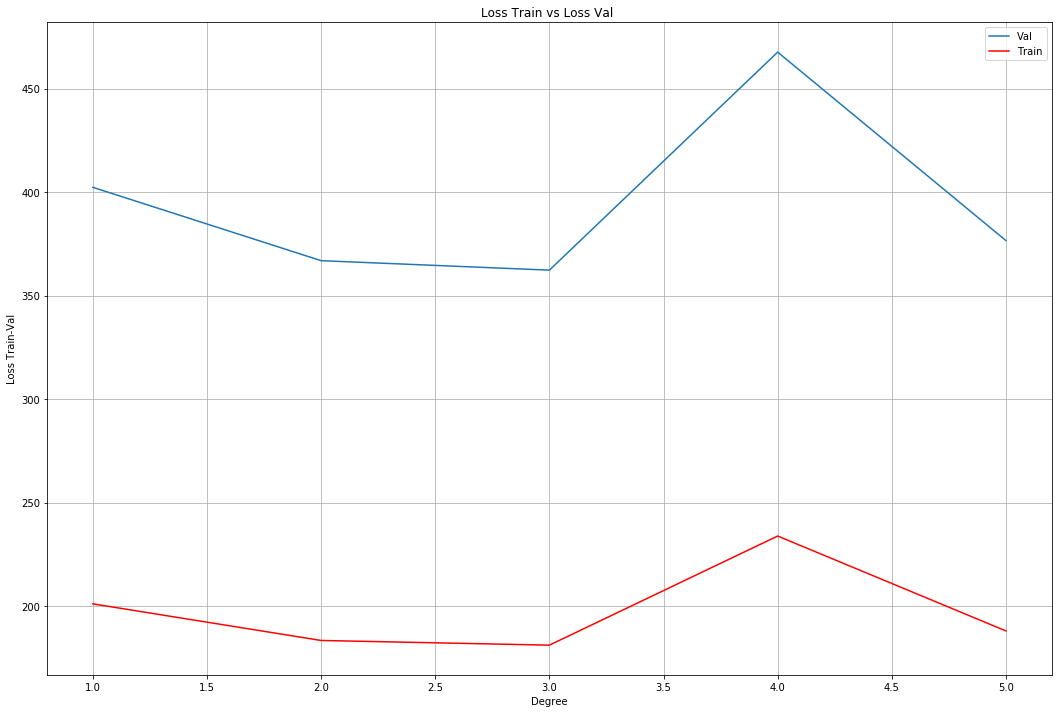

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [12]:
fig = plot_figures(degrees,loss_train_plot, loss_val_plot, "Loss Train vs Loss Val ", ['Val', 'Train'], "Loss Train-Val", "Degree")
fig.savefig('../results/Loss_trainvsval.eps', format= 'eps')


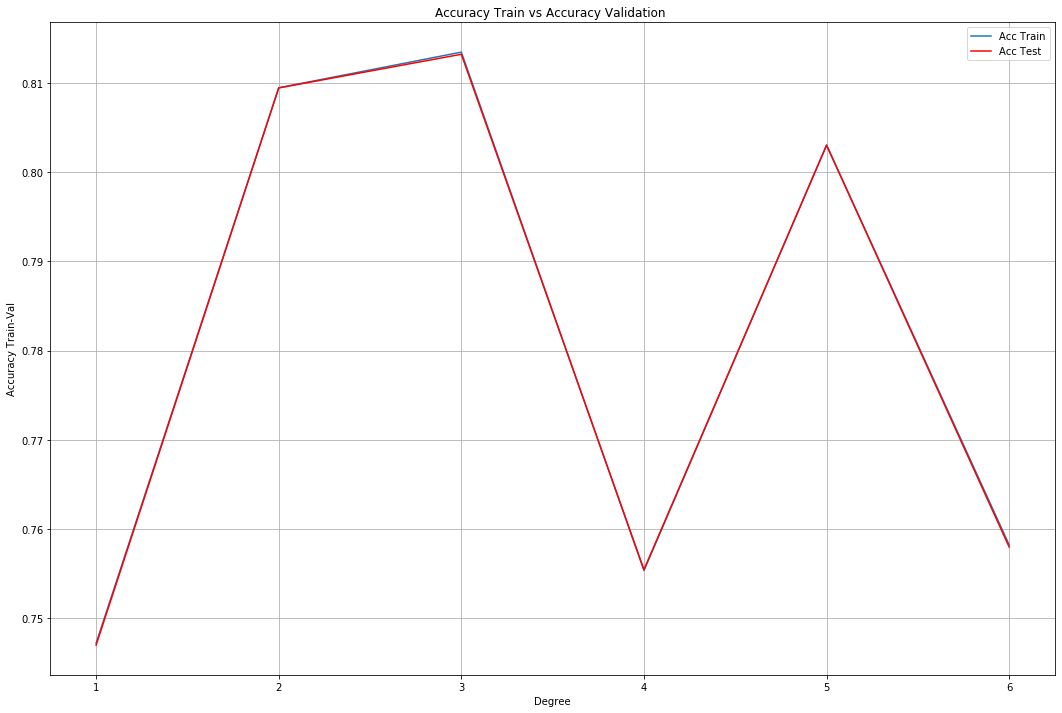

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [13]:
fig = plot_figures(degrees,acc_train_plot, acc_val_plot, "Accuracy Train vs Accuracy Validation ", ['Acc Train', 'Acc Test'],"Accuracy Train-Val", "Degree")
fig.savefig('../results/Acc_trainvsval.eps', format= 'eps')

In [42]:
acc_train_plot

[0.67671625]

In [43]:
acc_val_plot

[0.6766650000000001]

In [24]:
acc_val_plot_t = [i * 100 for i in acc_val_plot]
acc_val_plot_t

[74.5435, 80.744, 81.1535, 79.2685, 79.674, 77.364]

In [26]:
acc_train_plot

[0.17994000000000002,
 0.23041874999999998,
 0.23483749999999998,
 0.25893749999999993,
 0.22010749999999998,
 0.24214249999999998]

In [ ]:
accuracy_val

## Generate predictions and save ouput in csv format for submission:

In [13]:
y_pred = predict_labels(weights, x_test)
np.unique(y_pred)
y_pred.size

568238

In [14]:
OUTPUT_PATH = '../results/TEST.csv' 
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [15]:
# Script to delete empty rows
with open('../results/TEST.csv') as input, open('../results/TEST_cleaned.csv', 'w', newline='') as output:
    writer = csv.writer(output)
    for row in csv.reader(input):
        if any(field.strip() for field in row):
            writer.writerow(row)

In [18]:
# Preprocessing of Training 

cat_cols = [22]
full_x_train_num, full_x_train_cat = split_numerical_categorical(tX_trainRaw,cat_cols)

# Treat numerical values
full_x_train_num_nan = replace_undef_val_with_nan(full_x_train_num)
full_x_train_num_nan_std, train_mean, train_std = nan_standardize_fit(full_x_train_num_nan)

full_x_train_num_valid_std = replace_nan_val_with_median(full_x_train_num_nan_std)
full_x_train_num_valid_std = replace_iqr_outliers(full_x_train_num_valid_std)

# Treat categorical values
full_x_train_ohe_cat = one_hot_encode(full_x_train_cat)
x_train_poly = build_poly(full_x_train_num_valid_std,3)
full_x_train = np.hstack((x_train_poly,full_x_train_ohe_cat))

# Treat labels
full_y_train = y_trainRaw
full_y_train = relabel_y_non_negative(full_y_train).reshape(-1,1)
full_y_train = full_y_train.reshape(-1,1)

In [19]:
# Split in train and validation set
x_train, y_train, x_val, y_val = split_data(tX_trainRaw,full_y_train,0.8)


In [20]:
# Preprocessing of Test

cat_cols = [22]
x_test_num, x_test_cat = split_numerical_categorical(tX_testRaw,cat_cols)

# Treat numerical values
x_test_num_nan = replace_undef_val_with_nan(x_test_num)
x_test_num_nan_std = nan_standardize_transform(x_test_num_nan,train_mean,train_std)
x_test_num_valid_std = replace_nan_val_with_median(x_test_num_nan_std)
x_test_num_valid_std = replace_iqr_outliers(x_test_num_valid_std)
x_test_ohe_cat = one_hot_encode(x_test_cat)
x_test_poly = build_poly(x_test_num_valid_std,3)
x_test = np.hstack((x_test_poly,x_test_ohe_cat))


In [26]:
max_iters = 1000
gamma = 0.000000000000022
lambda_ = 0.001
w_initial = np.zeros((x_train.shape[1], 1))
weights,_ = reg_logistic_regression(y_train, x_train, w_initial, max_iters, gamma, lambda_)

#Iteration: 0, Loss: 138629.4361119856
#Iteration: 250, Loss: 126297.47056455349
#Iteration: 500, Loss: 125279.38550868873
#Iteration: 750, Loss: 124901.25217796533
#Iteration: 1000, Loss: 124591.73169925899


In [27]:
y_val = relabel_y_negative(y_val)
y_pred = predict_labels(weights, x_val)
accuracy_score(y_val,y_pred)

0.63992

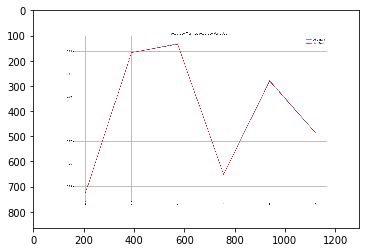

In [28]:
import matplotlib.image as img 
  
# reading png image file 
im = img.imread('../results/Acc_trainvsval.png') 
  
# show image 
plt.imshow(im) 